# Final Distribution

In [1]:
from config import PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    CITIZENS_AUDIENCE, ETH_ANALYSIS_DATASET_NAME, ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    CRYPTOPUNKS_AUDIENCE, \
    HACKERS_AUDIENCE, GAS_ANALYSIS_DATASET_NAME, GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    LEADERS_AUDIENCE, ERC20_TOP_DISTRIBUTION_TABLE_NAME, \
    MASTERS_AUDIENCE, ERC721_ANALYSIS_DATASET_NAME, ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    INVESTORS_AUDIENCE, ERC20_ANALYSIS_DATASET_NAME, ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    HEROES_AUDIENCE, GENESIS_AND_ETH2_DATASET_NAME, GENESIS_AND_ETH2_DISTRIBUTION_TABLE_NAME, \
    COSMOS_AUDIENCE, COSMOS_DATASET_NAME, COSMOS_DISTRIBUTION_TABLE_NAME, \
    MANUAL_ADDRESSES_AUDIENCE, MANUAL_ADDRESSES_DATASET_NAME, MANUAL_ADDRESSES_DISTRIBUTION_TABLE_NAME, \
    FINAL_DATASET_NAME, FINAL_DISTRIBUTION_VIEW_NAME, CONTRACT_ADDRESSES_TABLE, GIFT_PER_ADDRESS_PIVOT_VIEW_NAME
from src.utils_bigquery import create_view, create_table, drop_table, get_df
from src.utils_charts import heatmap_from_df


CREATE_CONTRACT_TABLE = False
DROP_TABLES = True
CREATE_TABLES = True
DROP_VIEW = True
CREATE_VIEW = True

## Set cyberGift for the Audiences
**Total Supply:** 1 PCYB = 1e15 CYB


**1% of Total Supply:** 10 TCYB = 1e13 CYB


Distribution between **audiences**


<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th>Audience</th>
            <th>Share of Total Supply</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Average Citizens </td>
            <td style="text-align: center"> 35% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Cyberpunks </td>
            <td style="text-align: center"> 1% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Extraordinary Hackers </td>
            <td style="text-align: center"> 7% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Key Opinion Leaders </td>
            <td style="text-align: center"> 2% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Masters of the Great Web </td>
            <td style="text-align: center"> 13% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Passionate Investors </td>
            <td style="text-align: center"> 3% </td>
        </tr>
        <tr>
            <td style="text-align: left"> True Heroes of the Great Web </td>
            <td style="text-align: center"> 5% </td>
        </tr>
    </tbody>
</table>

In [2]:
gift_per_audience = {
    CITIZENS_AUDIENCE : 35e13,
    CRYPTOPUNKS_AUDIENCE: 1e13,
    HACKERS_AUDIENCE: 7e13,
    LEADERS_AUDIENCE: 2e13,
    MASTERS_AUDIENCE: 13e13,
    INVESTORS_AUDIENCE: 3e13,
    HEROES_AUDIENCE: 5e13,
    COSMOS_AUDIENCE: 1e13
}

## Create Contracts Table

In [3]:
query_1 = f'''
    SELECT
        to_address as address
    FROM `bigquery-public-data.crypto_ethereum.traces`
    WHERE block_timestamp >= '{INITIAL_TS}'
      AND block_timestamp <= '{SNAPSHOT_TS}'
      AND trace_type ='create'
      AND status = 1
'''

if CREATE_CONTRACT_TABLE:
    if DROP_TABLES:
        drop_table(table_name=CONTRACT_ADDRESSES_TABLE,
                   dataset_name=FINAL_DATASET_NAME)
    if CREATE_TABLES:
        create_table(query_1=query_1,
                     table_name=CONTRACT_ADDRESSES_TABLE,
                     dataset_name=FINAL_DATASET_NAME)

## Create View

In [4]:
query_1 = f'''
    SELECT
        audience,
        subtype,
        address,
        grade
    FROM (
        SELECT
            '{HEROES_AUDIENCE}' AS audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{GENESIS_AND_ETH2_DATASET_NAME}.{GENESIS_AND_ETH2_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            IF(subtype = 'Contract Creator by Factory', '{MASTERS_AUDIENCE}', '{HACKERS_AUDIENCE}') AS audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            '{CITIZENS_AUDIENCE}' AS audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ETH_ANALYSIS_DATASET_NAME}.{ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            audience,
            subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            '{LEADERS_AUDIENCE}' AS audience,
            '{LEADERS_AUDIENCE}' AS subtype,
            address,
            grade
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOP_DISTRIBUTION_TABLE_NAME}`
        WHERE grade IS NOT NULL

        UNION ALL

        SELECT
            '{MANUAL_ADDRESSES_AUDIENCE}' AS audience,
            '{MANUAL_ADDRESSES_AUDIENCE}' AS subtype,
            address,
            3 AS grade
        FROM `{PROJECT_ID}.{MANUAL_ADDRESSES_DATASET_NAME}.{MANUAL_ADDRESSES_DISTRIBUTION_TABLE_NAME}`
        )
    WHERE address NOT IN (SELECT address FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{CONTRACT_ADDRESSES_TABLE}`)

    UNION ALL

    SELECT
        '{COSMOS_AUDIENCE}' AS audience,
        'ATOM Balances' AS subtype,
        address,
        grade
    FROM `{PROJECT_ID}.{COSMOS_DATASET_NAME}.{COSMOS_DISTRIBUTION_TABLE_NAME}`
    WHERE grade IS NOT NULL
'''

if DROP_VIEW:
    drop_table(table_name=FINAL_DISTRIBUTION_VIEW_NAME,
               dataset_name=FINAL_DATASET_NAME)

if CREATE_VIEW:
    create_view(query=query_1,
                view_name=FINAL_DISTRIBUTION_VIEW_NAME)

Table final:final_distribution has been deleted.
View VIEW:cosmic-keep-223223.final.final_distribution has been created.


In [5]:
query_2 = f'''
    SELECT
        audience,
        grade_1 as `Number_of_addresses_in_Grade_1`,
        ROUND(IF(grade_1 > 0, gift_amount_per_audience / grade_1 / number_of_grades / 1e6, 0), 2) as `Gift_per_address_for_Grade_1`,
        grade_2 as `Number_of_addresses_in_Grade_2`,
        ROUND(IF(grade_2 > 0, gift_amount_per_audience / grade_2 / number_of_grades / 1e6, 0), 2) as `Gift_per_address_for_Grade_2`,
        grade_3 as `Number_of_addresses_in_Grade_3`,
        ROUND(IF(grade_3 > 0, gift_amount_per_audience / grade_3 / number_of_grades / 1e6, 0), 2) as `Gift_per_address_for_Grade_3`,
        total_addresses as `Number_of_addresses_in_audience`,
        gift_amount_per_audience as `Gift_amount_per_audience`
    FROM (
        SELECT
            audience,
            SUM(IF(grade=1, address_count, 0)) as grade_1,
            SUM(IF(grade=2, address_count, 0)) as grade_2,
            SUM(IF(grade=3, address_count, 0)) as grade_3,
            SUM(address_count) as total_addresses,
            COUNTIF(address_count > 0) as number_of_grades
        FROM (
            SELECT
                audience,
                grade,
                count(distinct address) as address_count
            FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{FINAL_DISTRIBUTION_VIEW_NAME}`
            WHERE grade IN (1, 2, 3)
            GROUP BY audience, grade)
        GROUP BY audience)
    LEFT JOIN (
        SELECT
            gift.audience as audience,
            gift.amount_per_audience as gift_amount_per_audience
        FROM UNNEST([{''.join(f"STRUCT('{k}' AS audience, {v} AS amount_per_audience), " for k,v in gift_per_audience.items())[:-2]}]) as gift
        )
    USING (audience)
'''

if DROP_VIEW:
    drop_table(table_name=GIFT_PER_ADDRESS_PIVOT_VIEW_NAME,
               dataset_name=FINAL_DATASET_NAME)

if CREATE_VIEW:
    create_view(query=query_2,
                view_name=GIFT_PER_ADDRESS_PIVOT_VIEW_NAME)

Table final:gift_per_address_pivot has been deleted.
View VIEW:cosmic-keep-223223.final.gift_per_address_pivot has been created.


### Distribution Heatmap

In [6]:
query_3 = f'''
    SELECT
        ANY_VALUE(audiences) AS audiences,
        count(address) AS address_count
    FROM (
        SELECT
            address,
            ARRAY_AGG(DISTINCT audience) as audiences
        FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{FINAL_DISTRIBUTION_VIEW_NAME}`
        WHERE audience NOT IN ('{COSMOS_AUDIENCE}')
        GROUP BY address)
    GROUP BY TO_JSON_STRING(audiences)
'''

final_distribution_df = get_df(query_3)

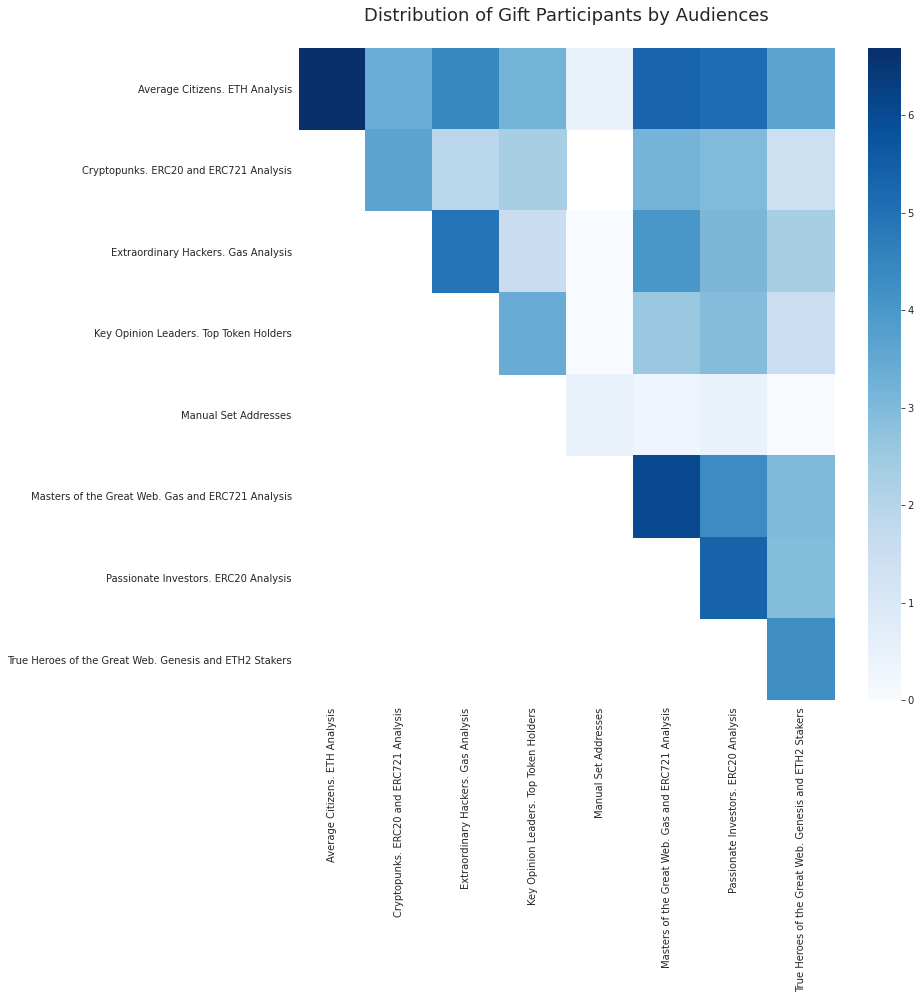

In [7]:
heatmap_from_df(final_distribution_df,
                title='Distribution of Gift Participants by Audiences\n',
                fig_size=12)